In [4]:
# 데이터 로드
import pandas as pd

train = pd.read_csv('C:/Users/sport/OneDrive/바탕 화면/VSC/train.csv')
valid = pd.read_csv('C:/Users/sport/OneDrive/바탕 화면/VSC/valid.csv')

In [5]:
import pandas as pd

# clickbait=0, clickbait=1 각각 4만개씩 샘플링
train_clickbait_0 = train[train['clickbaitClass'] == 0].sample(n=40000, random_state=42)
train_clickbait_1 = train[train['clickbaitClass'] == 1].sample(n=40000, random_state=42)
train_sampled = pd.concat([train_clickbait_0, train_clickbait_1], ignore_index=True)

# clickbait=0, clickbait=1 각각 1만개씩 샘플링
valid_clickbait_0 = valid[valid['clickbaitClass'] == 0].sample(n=10000, random_state=42)
valid_clickbait_1 = valid[valid['clickbaitClass'] == 1].sample(n=10000, random_state=42)
valid_sampled = pd.concat([valid_clickbait_0, valid_clickbait_1], ignore_index=True)

# 데이터 확인
print(train_sampled['clickbaitClass'].value_counts())
print(valid_sampled['clickbaitClass'].value_counts())

clickbaitClass
0    40000
1    40000
Name: count, dtype: int64
clickbaitClass
0    10000
1    10000
Name: count, dtype: int64


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# 데이터 추출
X_train = train_sampled['newsContent'].tolist()
y_train = train_sampled['clickbaitClass'].tolist()
X_val = valid_sampled['newsContent'].tolist()
y_val = valid_sampled['clickbaitClass'].tolist()

In [7]:
# 텍스트 토크나이저 설정
tokenizer = Tokenizer(num_words=5000)  # 상위 5000개의 단어만 사용
tokenizer.fit_on_texts(X_train)

In [8]:
# 텍스트를 시퀀스로 변환
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [9]:
# 시퀀스 길이 찾기
max_len_train = max(len(seq) for seq in X_train_seq)
max_len_val = max(len(seq) for seq in X_val_seq)
max_len = max(max_len_train, max_len_val)

In [10]:
# 시퀀스 길이를 동일하게 패딩
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

In [11]:
# 레이블을 numpy 배열로 변환
y_train = np.array(y_train)
y_val = np.array(y_val)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# LSTM 모델 구축
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128 ))
model.add(LSTM(64, return_sequences=True))  
model.add(Dropout(0.4))  # 드롭아웃 확률 증가
model.add(LSTM(32))  
model.add(Dropout(0.4))  # 드롭아웃 확률 증가
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_val_pad, y_val), callbacks=[early_stopping])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1324s 1s/step - accuracy: 0.5625 - loss: 0.6797 - val_accuracy: 0.6175 - val_loss: 0.6576
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1231s 985ms/step - accuracy: 0.6372 - loss: 0.6418 - val_accuracy: 0.5662 - val_loss: 0.6824
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1351s 1s/step - accuracy: 0.6459 - loss: 0.6292 - val_accuracy: 0.6308 - val_loss: 0.6403
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1332s 1s/step - accuracy: 0.7056 - loss: 0.5750 - val_accuracy: 0.6726 - val_loss: 0.6126
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1843s 1s/step - accuracy: 0.7429 - loss: 0.5276 - val_accuracy: 0.6773 - val_loss: 0.6129
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1486s 1s/step - accuracy: 0.7746 - loss: 0.4850 - val_accuracy: 0.6723 - val_loss: 0.6366


In [13]:
# 모델 평가
loss, accuracy = model.evaluate(X_val_pad, y_val)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

625/625 ━━━━━━━━━━━━━━━━━━━━ 131s 210ms/step - accuracy: 0.6853 - loss: 0.6437
Validation Loss: 0.6126123666763306
Validation Accuracy: 0.6725999712944031


In [20]:
from sklearn.metrics import classification_report

# 정확도, F1 스코어, 재현율 등의 지표 출력
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_class, target_names=['Non-Clickbait', 'Clickbait']))


Classification Report:
               precision    recall  f1-score   support

Non-Clickbait       0.67      0.69      0.68     10000
    Clickbait       0.68      0.65      0.67     10000

     accuracy                           0.67     20000
    macro avg       0.67      0.67      0.67     20000
 weighted avg       0.67      0.67      0.67     20000



625/625 ━━━━━━━━━━━━━━━━━━━━ 187s 265ms/step


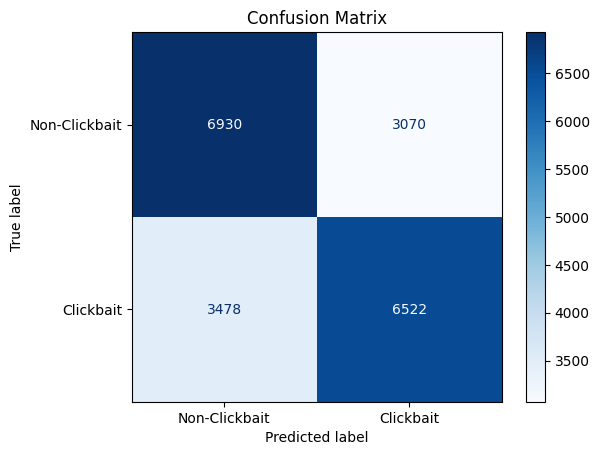

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Validation 데이터에 대한 예측
y_val_pred = model.predict(X_val_pad)
y_val_pred_class = (y_val_pred > 0.5).astype(int).flatten()  # 0.5 이상이면 1, 미만이면 0

# 혼동 행렬 계산
cm = confusion_matrix(y_val, y_val_pred_class)

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Clickbait', 'Clickbait'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [18]:
# 새로운 기사 예측
new_article = ["내년도 최저임금 심의에서 업종별 차등적용 도입 방안이 가시화되고 있다. 최저임금 업종별 차등적용에 대한 정부의 의지가 강한데다, 최근 새롭게 구성된 공익위원들도 보수색이 짙어 지난해와는 전혀 다른 양상이다. 내년에 차등적용이 현실화될 경우 지난 1989년 이후 36년만에 도입된다. 특히 최저임금의 업종별 차등적용은 윤석열 대통령의 대선 공약이다. 지난달 열린 민생토론회에서도 외국인 유학생과 이민자의 가사·육아 취업 필요성을 언급하며, 최저임금 제한 없이 일할 수 있어야 유연한 노동시장이 만들어질 수 있다고 강조했다."]
new_article_seq = tokenizer.texts_to_sequences(new_article)
new_article_pad = pad_sequences(new_article_seq, maxlen=max_len)
prediction = model.predict(new_article_pad)
print(f'Prediction: {prediction[0][0]}')  # 0.5 이상이면 unbait, 이하이면 bait

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Prediction: 0.48035532236099243


In [19]:
# 새로운 기사 예측
new_article = ["경찰은 불법촬영 신고 건수가 늘어나고 있다면서도 정확한 기준선이 없어 난감하다는 입장이다. 관련 업무를 담당하는 한 경찰 관계자는 의사에 반해 특정 부위 등을 반복해 촬영한 것이면 당연히 불법행위가 되지만 단순히 길거리를 촬영한 영상이면 현장에서 판단이 어려운 것은 사실이라며 사안에 따라 성범죄 전과 등 종합적으로 판단해 수사하고 있다고 설명했다. 법조계는 이같은 영상 촬영이 사전 동의 없이 이뤄지거나 특정 인물을 부각해 반복적으로 찍었다면 불법 소지가 있다고 경고한다. 지난 1월 대법원은 버스에서 레깅스 차림의 여성을 8초가량 촬영한 남성을 일상복을 입었다고 해 성적 욕망의 대상이 아니라고 단정할 수는 없다며 유죄로 판단한 바 있다. 의사에 반해 성적 대상화 우려가 있는 촬영은 불법이라는 의미다. 김기윤 변호사는 특정인물의 얼굴 역시 개인정보에 해당하기 때문에 이를 찍어 공개한 것은 개인정보보호법 위반에 해당할 소지가 있다며 특정 여성의 신체부위가 노출된 영상이라면 얼굴 노출 여부와 촬영 구도 등을 종합적으로 따져 성폭력범죄의 처벌 등에 관한 특례법 위반(카메라 등을 이용한 촬영)이 적용된다고 판단할 수 있다고 지적했다. "]
new_article_seq = tokenizer.texts_to_sequences(new_article)
new_article_pad = pad_sequences(new_article_seq, maxlen=max_len)
prediction = model.predict(new_article_pad)
print(f'Prediction: {prediction[0][0]}')  # 0.5 이상이면 bait, 이하이면 unbait

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Prediction: 0.7689980268478394
